In [ ]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

<h1>Purpose</h1>

<p> Magnetic Resonance imaging is widely used by medical professionals for the visualisation of anatomical structures and the detection of pathological lesions. Brain tissue intensity is the core feature being analysed when performing MRI's on the brain.
    
This project will use a deep auto-encoder based upon the UNet architecture to segment and classify typically homogenous and noisy brain MRI's into the three specific tissue types: White Matter, Gray Matter and Cerebrospinal fluid.  

These brain slice segmentations are useful for applications such as surgical planning and anomaly detection.</p>

<h1>Data Exploration and Preprocessing</h1>

In [ ]:
# MRI OASIS Brain Imaging (https://www.oasis-brains.org/)

# Path to Local Brain MRI OASIS Dataset 
import os

data_dir = './keras_png_slices_data' 

os.listdir(data_dir)

['test', 'train', 'validate']

In [ ]:
# Let's review some of the brain slices and the target brain segmentation.
from matplotlib.image import imread

# Training Data
x_train_path = data_dir + '/train/train/slice'
y_train_path = data_dir + '/train/masks/seg'

# Validation Data
x_validate_path = data_dir + '/validate/validate_train/slice'
y_validate_path = data_dir + '/validate/validate_masks/seg'

os.listdir(x_train_path)[:5] #List all the training brain slices in the training folder.

['case_001_slice_0.nii.png',
 'case_001_slice_1.nii.png',
 'case_001_slice_10.nii.png',
 'case_001_slice_11.nii.png',
 'case_001_slice_12.nii.png']

In [ ]:
# Let's Visualise the Training Brain Slices and Target Brain Segmentations

from matplotlib.pyplot import figure, imshow, axis, title

list_of_brain_slices = []
list_of_brain_segments = []

for brain_segments in os.listdir(y_train_path)[:5]:
    example_training_segment = y_train_path + '/' + brain_segments
    list_of_brain_segments.append(imread(example_training_segment))

for brain_slices in os.listdir(x_train_path)[:5]:
    example_training_slice = x_train_path + '/' + brain_slices
    list_of_brain_slices.append(imread(example_training_slice))

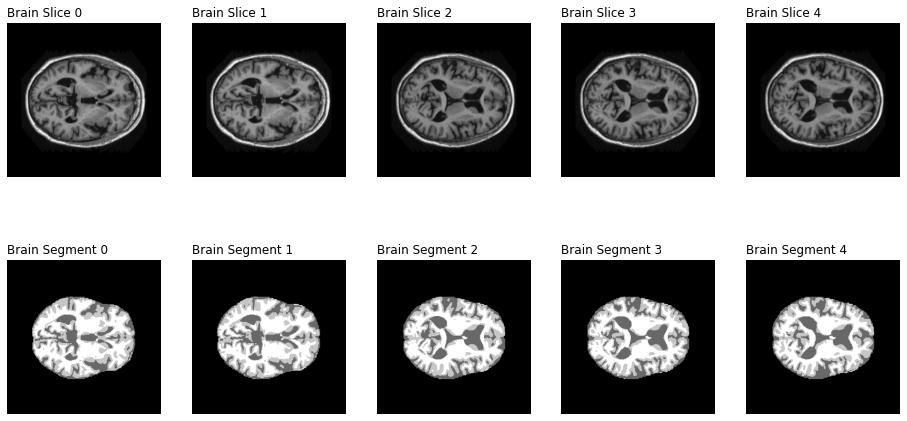

In [ ]:
fig = figure(figsize=(16,16))
number_of_slices = len(list_of_brain_slices)
number_of_segments = len(list_of_brain_segments)

for i in range(number_of_segments):
    a=fig.add_subplot(1,5,i+1)
    imshow(list_of_brain_segments[i],cmap='Greys_r')
    axis('off')
    title('Brain Segment' + ' %i' %i, loc='left')
    
for i in range(number_of_slices):
    a=fig.add_subplot(2,5,i+1)
    imshow(list_of_brain_slices[i],cmap='Greys_r')
    axis('off')
    title('Brain Slice' + ' %i' %i, loc='left')
    

<AxesSubplot:>

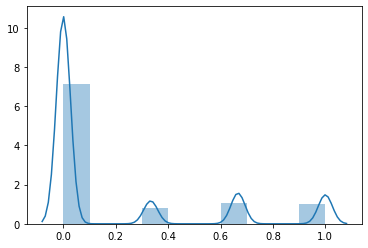

In [ ]:
# Distribution to Determine Number of Classes (Unique Pixel Values)
import seaborn as sns

sns.distplot(list_of_brain_segments, bins=10)

256.0
256.0


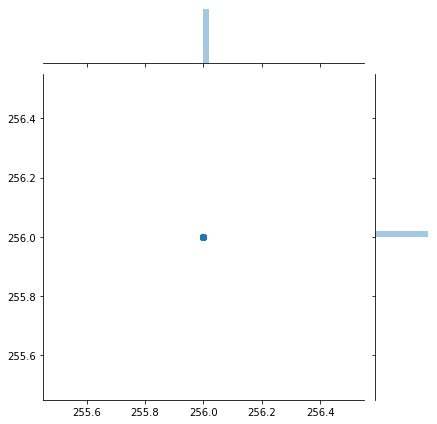

In [ ]:
# Analyse the distribution of image height and width
dim1_x_train = []
dim2_x_train = []

for image_filename in os.listdir(x_train_path):
    
    img = imread(x_train_path + '/' + image_filename)
    d1, d2 = img.shape
    dim1_x_train.append(d1)
    dim2_x_train.append(d2)
    
sns.jointplot(dim1_x_train, dim2_x_train)
print(np.mean(dim1_x_train))
print(np.mean(dim2_x_train))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generation = ImageDataGenerator(rescale = 1. / 255)

# For our mask generator (rescale from 1/3 to 3).
one_hot_encode = ImageDataGenerator(rescale = 3. / 255)

In [ ]:
# Training Brain Slices and Target Brain Segments
train_gen = image_generation.flow_from_directory('keras_png_slices_data/train/train',
                                                      target_size=(256, 256),
                                                      color_mode="grayscale",
                                                      class_mode=None,
                                                        shuffle=False,
                                                      batch_size=24)


mask_gen = one_hot_encode.flow_from_directory('keras_png_slices_data/train/masks',
                                                      target_size=(256, 256),
                                                      color_mode="grayscale",
                                                      class_mode=None,
                                                        shuffle=False,
                                                      batch_size=24)

# combine generators into one which yields image and masks
train_generator = zip(train_gen, mask_gen)

Found 9664 images belonging to 1 classes.
Found 9664 images belonging to 1 classes.


In [ ]:
# Validation Brain Slices and Target Brain Segments
validation_train_gen = image_generation.flow_from_directory('keras_png_slices_data/validate/validate_train',
                                                      target_size=(256, 256),
                                                      color_mode="grayscale",
                                                      class_mode=None,
                                                       shuffle=False,
                                                      batch_size=24)

validation_mask_gen = one_hot_encode.flow_from_directory('keras_png_slices_data/validate/validate_masks',
                                                      target_size=(256, 256),
                                                      color_mode="grayscale",
                                                      class_mode=None,
                                                       shuffle=False,
                                                      batch_size=24)

validation_generator = zip(validation_train_gen, validation_mask_gen)

Found 1120 images belonging to 1 classes.
Found 1120 images belonging to 1 classes.


<h1>Check the Target Brain Segmentations are Hot Encoded </h1>

In [ ]:
print(validation_mask_gen[1][0].shape) 
print(validation_train_gen[1][0].shape)

(256, 256, 1)
(256, 256, 1)


<h1>Build the UNet-Based Architecture for Autoencoding</h1>

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, concatenate, Dense, Flatten
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Conv2DTranspose, Reshape
from tensorflow.keras.metrics import MeanIoU

In [ ]:
input_layer = tf.keras.layers.Input(shape=(256,256,1))

# Contraction Phase 1
contraction1 = Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu")(input_layer)
contraction1 = Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu")(contraction1)
max1 = MaxPool2D((2,2))(contraction1)
pool1 = Dropout(0.25)(max1)

# Contraction Phase 2
contraction2 = Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation="relu")(pool1)
contraction2 = Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation="relu")(contraction2)
max2 = MaxPool2D((2,2))(contraction2)
pool2 = Dropout(0.5)(max2)

# Contraction Phase 3
contraction3 = Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation="relu")(pool2)
contraction3 = Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation="relu")(contraction3)
max3 = MaxPool2D((2,2))(contraction3)
pool3 = Dropout(0.5)(max3)

# Contraction Phase 4
contraction4 = Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu")(pool3)
contraction4 = Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu")(contraction4)
max4 = MaxPool2D((2,2))(contraction4)
pool4 = Dropout(0.5)(max4)

# Contraction Phase 5
contraction5 = Conv2D(filters = 256, kernel_size=(3,3), padding="same", activation="relu")(pool4)
contraction5 = Conv2D(filters = 256, kernel_size=(3,3), padding="same", activation="relu")(contraction5)

# Upsample from 28 x 28 x 1024 to 56 x 56 x 512
trans1 = Conv2DTranspose(filters=(128), kernel_size=(3,3), strides=(2, 2), padding="same")(contraction5)
combine1 = concatenate([trans1, contraction4])
combine1 = Dropout(0.5)(combine1)
expansion1 = Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu")(combine1)
expansion1 = Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu")(expansion1)

# Upsample from 52 x 52 to 104 x 104
trans2 = Conv2DTranspose(filters=(64), kernel_size=(3,3), strides=(2, 2), padding="same")(expansion1)
combine2 = concatenate([trans2, contraction3])
combine2 = Dropout(0.5)(combine2)
expansion2 = Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation="relu")(combine2)
expansion2 = Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation="relu")(expansion2)

# Upsample from 104 x 104 to 200 x 200
trans3 = Conv2DTranspose(filters=(32), kernel_size=(3,3), strides=(2, 2), padding="same")(expansion2)
combine3 = concatenate([trans3, contraction2])
combine3 = Dropout(0.5)(combine3)
expansion3 = Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation="relu")(combine3)
expansion3 = Conv2D(filters = 32, kernel_size=(3,3), padding="same", activation="relu")(expansion3)

# Upsample from 196 x 196 to 392 x 392
trans4 = Conv2DTranspose(filters=(16), kernel_size=(3,3), strides=(2, 2), padding="same")(expansion3)
combine4 = concatenate([trans4, contraction1])
combine4 = Dropout(0.5)(combine4)
expansion4 = Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu")(combine4)
expansion4 = Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu")(expansion4)

# Filter1: Background, Filter2: Cerebralspinal Fluid, Filter3: Gray Matter, Filter4: White Matter
output_layer = Conv2D(filters=4, kernel_size=(1,1), padding="same", activation="softmax")(expansion4)

In [ ]:
autoencoder = Model(input_layer, output_layer)

In [ ]:
m = MeanIoU(num_classes=4)

In [ ]:
autoencoder.compile(loss="sparse_categorical_crossentropy", 
                    optimizer="adam",
                   metrics=[m])

In [ ]:
autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
autoencoder.summary()

In [ ]:
# Steps per epoch = Total Number of Batches to Yield From Generator before declaring one epoch.
# Steps Per Epoch = 9664 (Samples) / 24 (Batch Size) = 400
Steps_Per_Epoch = np.ceil(9664/24)

Validation_Steps = np.ceil(1120 / 24) 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

checkpoint_filepath = './checkpoint'

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_best_only=True,verbose=1)
                                                         

In [ ]:
#tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=False)                                           

In [ ]:
early_stopping_callback = EarlyStopping(patience=5, verbose=1)

In [ ]:
autoencoder.fit(train_generator,
                steps_per_epoch=Steps_Per_Epoch,
                epochs=30,
                validation_data = validation_generator,
                validation_steps = Validation_Steps,
                callbacks=[model_checkpoint_callback,
                          early_stopping_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 403.0 steps, validate for 47.0 steps
Epoch 1/30
402/403 [============================>.] - ETA: 0s - loss: 0.1284 - accuracy: 0.9475
Epoch 00001: val_loss improved from 0.12104 to 0.09563, saving model to ./checkpoint
INFO:tensorflow:Assets written to: ./checkpoint\assets
403/403 [==============================] - 67s 166ms/step - loss: 0.1283 - accuracy: 0.9475 - val_loss: 0.0956 - val_accuracy: 0.9611
Epoch 2/30
402/403 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9535
Epoch 00002: val_loss improved from 0.09563 to 0.09350, saving model to ./checkpoint
INFO:tensorflow:Assets written to: ./checkpoint\assets
403/403 [==============================] - 67s 166ms/step - loss: 0.1139 - accuracy: 0.9535 - val_loss: 0.0935 - val_accuracy: 0.9612
Epoch 3/30
402/403 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9606
Epoch 00003: val_loss improved from 0.09350 to 0.07989, saving mode

Epoch 24/30
402/403 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9821
Epoch 00024: val_loss improved from 0.03592 to 0.03499, saving model to ./checkpoint
INFO:tensorflow:Assets written to: ./checkpoint\assets
403/403 [==============================] - 67s 165ms/step - loss: 0.0434 - accuracy: 0.9821 - val_loss: 0.0350 - val_accuracy: 0.9853
Epoch 25/30
402/403 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9826
Epoch 00025: val_loss improved from 0.03499 to 0.03231, saving model to ./checkpoint
INFO:tensorflow:Assets written to: ./checkpoint\assets
403/403 [==============================] - 66s 165ms/step - loss: 0.0418 - accuracy: 0.9826 - val_loss: 0.0323 - val_accuracy: 0.9865
Epoch 26/30
402/403 [============================>.] - ETA: 0s - loss: 0.0403 - accuracy: 0.9831
Epoch 00026: val_loss did not improve from 0.03231
403/403 [==============================] - 62s 154ms/step - loss: 0.0403 - accuracy: 0.9831 - val_loss: 0.0330

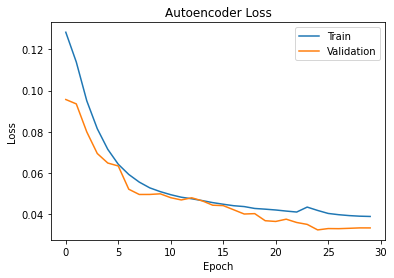

In [ ]:
# Training and Validation Loss
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

<h1>Loading the Checkpoint Autoencoder</h1>

In [ ]:
reloaded_model = tf.keras.models.load_model('./checkpoint')
reloaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 256, 256, 16) 160         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_171[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_172[0][0]                 
____________________________________________________________________________________________

In [ ]:
reloaded_model.fit(train_generator,
                steps_per_epoch=Steps_Per_Epoch,
                epochs=30,
                validation_data = validation_generator,
                validation_steps = Validation_Steps,
                callbacks=[early_stopping_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 403.0 steps, validate for 47.0 steps
Epoch 1/30
403/403 [==============================] - 71s 175ms/step - loss: 0.0406 - accuracy: 0.9831 - val_loss: 0.0345 - val_accuracy: 0.9856
Epoch 2/30
403/403 [==============================] - 63s 156ms/step - loss: 0.0402 - accuracy: 0.9832 - val_loss: 0.0330 - val_accuracy: 0.9862
Epoch 3/30
403/403 [==============================] - 63s 156ms/step - loss: 0.0398 - accuracy: 0.9833 - val_loss: 0.0328 - val_accuracy: 0.9862
Epoch 4/30
403/403 [==============================] - 63s 156ms/step - loss: 0.0392 - accuracy: 0.9836 - val_loss: 0.0335 - val_accuracy: 0.9859
Epoch 5/30
403/403 [==============================] - 63s 156ms/step - loss: 0.0388 - accuracy: 0.9837 - val_loss: 0.0329 - val_accuracy: 0.9861
Epoch 6/30
403/403 [==============================] - 63s 156ms/step - loss: 0.0386 - accuracy: 0.9838 - val_loss: 0.0322 - val_accuracy: 0.9865
Epoch 7/30
403/403 [=============

<h1>Brain Segmentation Testing</h1>

In [ ]:
brain_test1 = imread('./keras_png_slices_data/test/test/slice/case_441_slice_0.nii.png')
brain_test2 = imread('./keras_png_slices_data/test/test/slice/case_441_slice_1.nii.png')
brain_testing1 = brain_test1.reshape(1,256,256,1)
brain_testing2 = brain_test2.reshape(1,256,256,1)

In [ ]:
# Testing Data
x_test_path = data_dir + '/test/test/slice'
y_test_path = data_dir + '/test/masks/seg'

list_of_test_brain_slices = []

for test_brain_slices in os.listdir(x_test_path)[:45:8]:
    testing_slice = x_test_path + '/' + test_brain_slices
    list_of_test_brain_slices.append(imread(testing_slice))
    
list_of_segmented_brain_slices = []

for brain_slices in list_of_test_brain_slices:
    segmented_brain_slice = reloaded_model.predict(brain_slices.reshape(1,256,256,1))
    list_of_segmented_brain_slices.append(segmented_brain_slice)


In [ ]:
number_of_brain_slices = len(list_of_test_brain_slices)
print(number_of_brain_slices)
print(len(list_of_segmented_brain_slices))

6
6


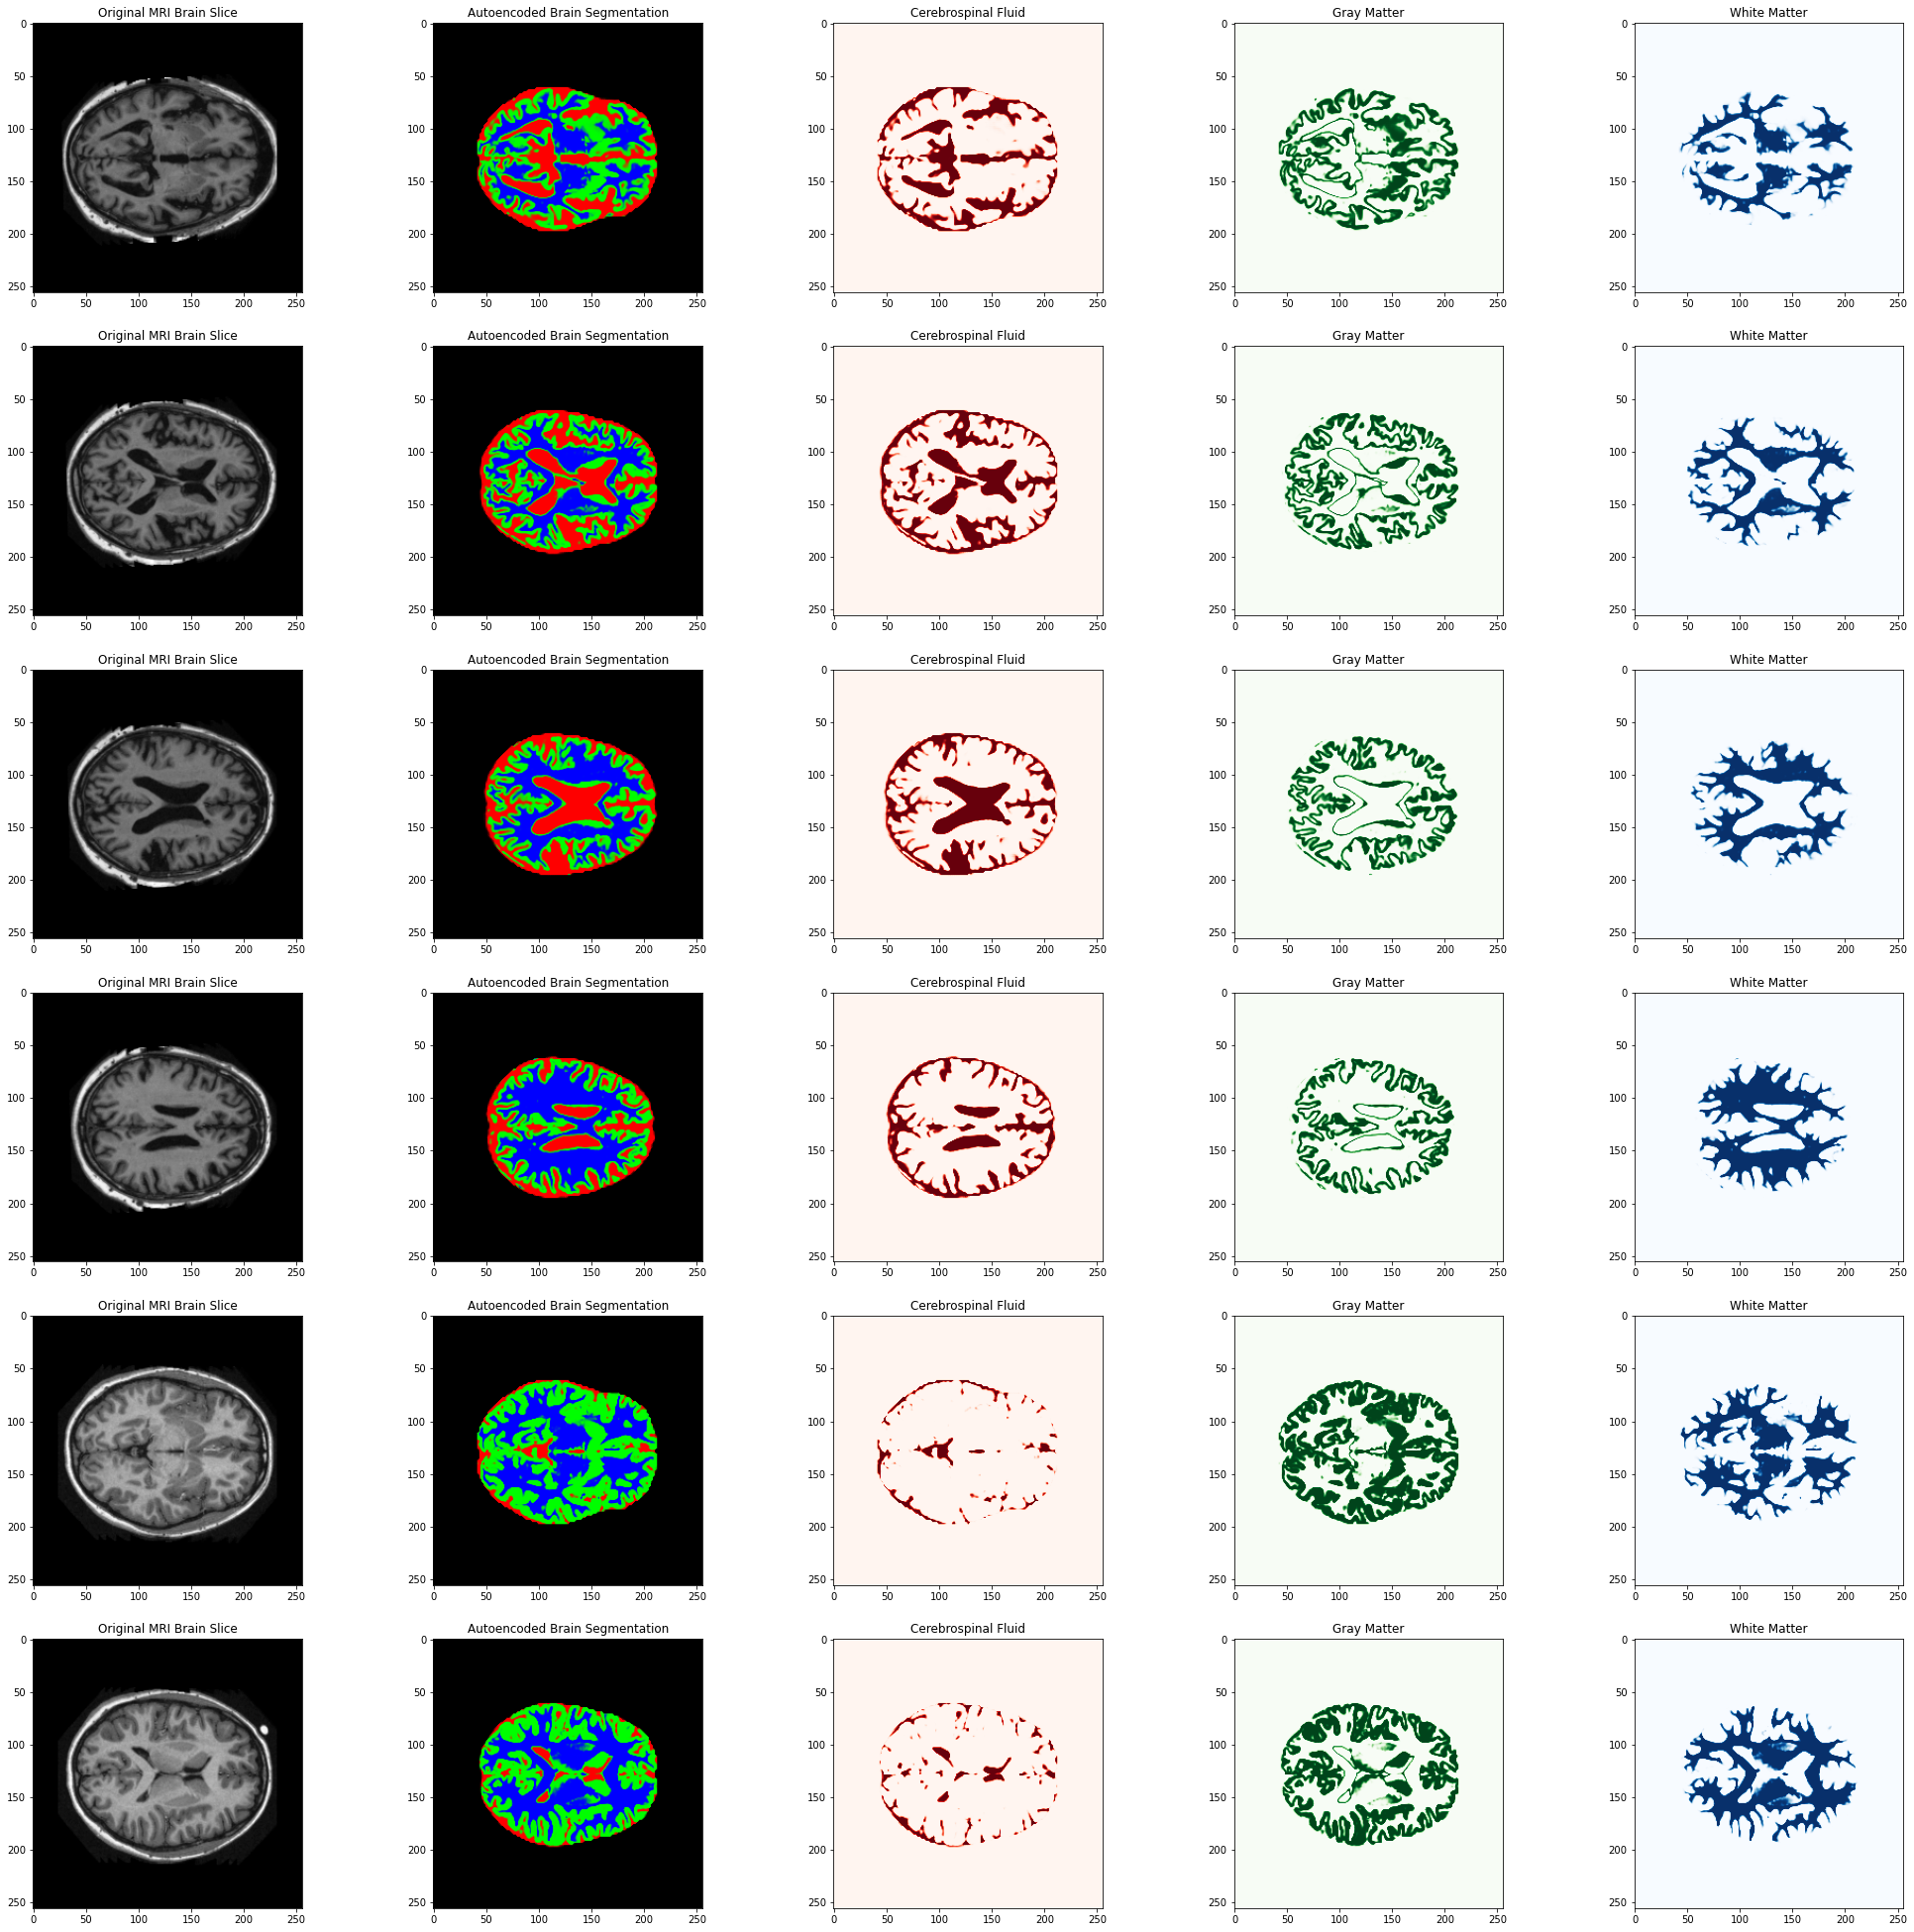

In [ ]:
#number_of_brain_slices = len(list_of_test_brain_slices)

uniq = number_of_brain_slices

fig, axr = plt.subplots(uniq, 5, figsize=(35, 35))


for k in range(number_of_brain_slices):
    

    for brains in list_of_segmented_brain_slices[k]:
        
      
        squeezed_brain = brains.squeeze();
        
        
        axr[k,0].title.set_text('Original MRI Brain Slice')
        axr[k,0].imshow(list_of_test_brain_slices[k], cmap='Greys_r')
        
        
        axr[k,1].title.set_text('Autoencoded Brain Segmentation')
        axr[k,1].imshow(squeezed_brain[:,0:256:,1:4])
       
        
        axr[k,2].title.set_text('Cerebrospinal Fluid')
        axr[k,2].imshow(squeezed_brain[:,0:256:,1], cmap='Reds')
       
        
        
        axr[k,3].title.set_text('Gray Matter')
        axr[k,3].imshow(squeezed_brain[:,0:256:,2], cmap='Greens')
        
        
        
        axr[k,4].title.set_text('White Matter')
        axr[k,4].imshow(squeezed_brain[:,0:256:,3], cmap='Blues')
        
       # BW Autoencoded Brain Segemtation
        #axr[k,1].title.set_text('Autoencoded Brain Segementation')
        #pred_mask = tf.argmax(brains, axis=-1)
        #print(pred_mask)
        #axr[k,1].imshow(pred_mask, cmap='Greys_r')
        

(1, 256, 256, 4)


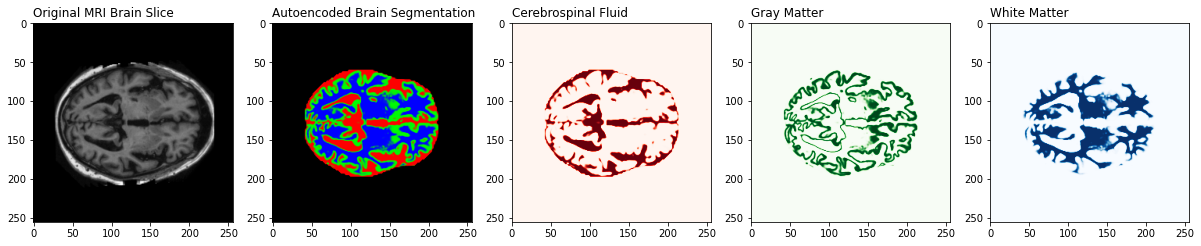

In [ ]:
# Autoencoded Segmentation
segmented_images_testing = autoencoder.predict(brain_testing1)
print(segmented_images_testing.shape)
new_channel = segmented_images_testing.squeeze()
#plt.imshow(segmented_images_testing.reshape(256,256), cmap='Greys_r')
fig = figure(figsize=(25,25))

a=fig.add_subplot(1,6,1)
title('Original MRI Brain Slice', loc='left')
plt.imshow(imread('./keras_png_slices_data/test/test/slice/case_441_slice_0.nii.png'), cmap='Greys_r')

a=fig.add_subplot(1,6,2)
title('Autoencoded Brain Segmentation', loc='left')
plt.imshow(new_channel[:,0:256:,1:4])

a=fig.add_subplot(1,6,3)
title('Cerebrospinal Fluid', loc='left')
plt.imshow(new_channel[:,0:256:,1], cmap='Reds')

a=fig.add_subplot(1,6,4)
title('Gray Matter', loc='left')
plt.imshow(new_channel[:,0:256:,2], cmap='Greens')

a=fig.add_subplot(1,6,5)
title('White Matter', loc='left')
plt.imshow(new_channel[:,0:256:,3], cmap='Blues')

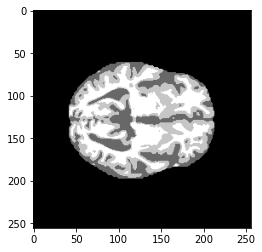

In [ ]:
# Target Segmentation
brain_test_seg1 = imread('./keras_png_slices_data/test/masks/seg/seg_441_slice_0.nii.png')
plt.imshow(brain_test_seg1.reshape(256,256), cmap='Greys_r')

In [ ]:
# Autoencoded Segmentation
brain_test3 = imread('./keras_png_slices_data/test/test/slice/case_445_slice_0.nii.png')
brain_testing3 = brain_test3.reshape(1,256,256,1)

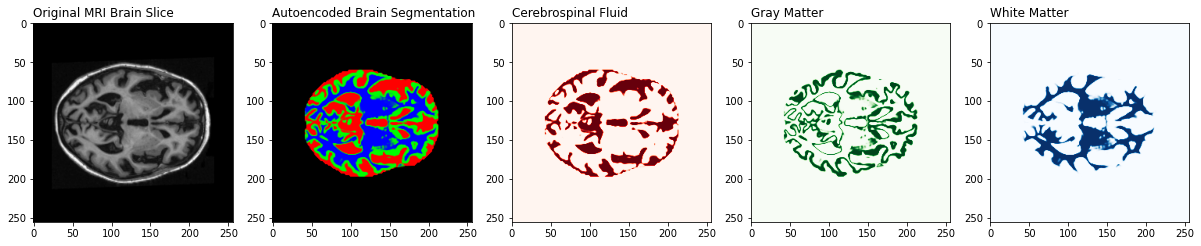

In [ ]:
segmented_images_testing3 = autoencoder.predict(brain_testing3)
# print(segmented_images_testing3.shape)
new_channel = segmented_images_testing3.squeeze()
# plt.imshow(segmented_images_testing.reshape(256,256), cmap='Greys_r')
fig = figure(figsize=(25,25))

a=fig.add_subplot(2,6,1)
title('Original MRI Brain Slice', loc='left')
plt.imshow(imread('./keras_png_slices_data/test/test/slice/case_445_slice_0.nii.png'), cmap='Greys_r')

a=fig.add_subplot(2,6,2)
title('Autoencoded Brain Segmentation', loc='left')
plt.imshow(new_channel[:,0:256:,1:4])

a=fig.add_subplot(2,6,3)
title('Cerebrospinal Fluid', loc='left')
plt.imshow(new_channel[:,0:256:,1], cmap='Reds')

a=fig.add_subplot(2,6,4)
title('Gray Matter', loc='left')
plt.imshow(new_channel[:,0:256:,2], cmap='Greens')

a=fig.add_subplot(2,6,5)
title('White Matter', loc='left')
plt.imshow(new_channel[:,0:256:,3], cmap='Blues')

Text(0.0, 1.0, 'Target Brain Segmentation')

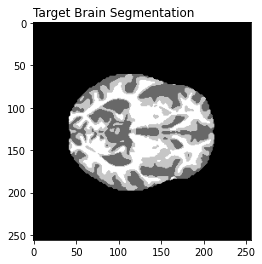

In [ ]:
# Target Segmentation
brain_test_seg3 = imread('./keras_png_slices_data/test/masks/seg/seg_445_slice_0.nii.png')
plt.imshow(brain_test_seg3.reshape(256,256), cmap='Greys_r')
title('Target Brain Segmentation', loc='left')

In [ ]:
# Testing Data
x_test_path = data_dir + '/test/test/slice'
y_test_path = data_dir + '/test/masks/seg'

list_of_target_segments = []
list_of_test_brain_slices = []

for test_brain_slices in os.listdir(x_test_path)[:50:10]:
    testing_slice = x_test_path + '/' + test_brain_slices
    list_of_test_brain_slices.append(imread(testing_slice))
    
for target_brain_segments in os.listdir(y_test_path)[:50:10]:
    target_segment = y_test_path + '/' + target_brain_segments
    list_of_target_segments.append(imread(target_segment))
    
list_of_segmented_brain_slices = []

for brain_slices in list_of_test_brain_slices:
    segmented_brain_slice = reloaded_model.predict(brain_slices.reshape(1,256,256,1))
    list_of_segmented_brain_slices.append(segmented_brain_slice)

In [ ]:
number_of_brain_slices = len(list_of_test_brain_slices)
print(number_of_brain_slices)
print(len(list_of_segmented_brain_slices))

In [ ]:
# Original vs Autoencoded vs Target Mask
#number_of_brain_slices = len(list_of_test_brain_slices)

uniq = number_of_brain_slices

fig, axr = plt.subplots(uniq, 3, figsize=(35, 35))


for k in range(number_of_brain_slices):
    

    for brains in list_of_segmented_brain_slices[k]:

        axr[k,0].title.set_text('Original MRI Brain Slice')
        axr[k,0].imshow(list_of_test_brain_slices[k], cmap='Greys_r')
                
       # BW Autoencoded Brain Segemtation
        axr[k,1].title.set_text('Autoencoded Brain Segementation')
        pred_mask = tf.argmax(brains, axis=-1)
        print(pred_mask)
        axr[k,1].imshow(pred_mask, cmap='Greys_r')
       
        # BW Target Brain Segmentation
        axr[k,2].title.set_text('Target Brain Segmentation')
        axr[k,2].imshow(list_of_target_segments[k], cmap='Greys_r')